In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
weather = pd.read_csv('./fullweather.csv')

In [3]:
weather

,Local time in Jeju (airport),T,WW
0,2019-04-16 1:00,11.6,NaN
1,2019-04-16 2:00,11.4,NaN
2,2019-04-16 3:00,11.4,NaN
3,2019-04-16 4:00,11.1,NaN
4,2019-04-16 5:00,11.2,NaN
...,...,...,...
74759,2021-06-02 20:00,22.0,NaN
74760,2021-06-02 21:00,22.0,NaN
74761,2021-06-02 22:00,22.1,NaN
74762,2021-06-02 23:00,22.6,NaN


In [4]:
weather['Local time in Jeju (airport)'] = pd.to_datetime(weather['Local time in Jeju (airport)'], format='%Y-%m-%d %H:%M', errors='raise')
weather['Date'] = weather['Local time in Jeju (airport)'].dt.date
weather['WW'][weather['WW'].notnull()] = 1
weather['WW'][weather['WW'].isnull()] = 0
weather['WW'] = pd.to_numeric(weather['WW'])


C:\Users\mllab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mllab\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
temp_rain = weather.groupby('Date',as_index=False).mean()
temp_rain.rename(columns={'WW':'rain'},inplace=True)
temp_rain['Date'] = temp_rain['Date'].astype(str)

In [6]:
temp_rain

,Date,T,rain
0,2019-04-16,15.939130,0.021739
1,2019-04-17,15.412500,0.083333
2,2019-04-18,15.431250,0.000000
3,2019-04-19,16.289583,0.000000
4,2019-04-20,16.446875,0.000000
...,...,...,...
775,2021-05-30,20.061458,0.000000
776,2021-05-31,20.938542,0.000000
777,2021-06-01,21.856250,0.000000
778,2021-06-02,22.740625,0.000000


In [7]:
weather

,Local time in Jeju (airport),T,WW,Date
0,2019-04-16 01:00:00,11.6,0.0,2019-04-16
1,2019-04-16 02:00:00,11.4,0.0,2019-04-16
2,2019-04-16 03:00:00,11.4,0.0,2019-04-16
3,2019-04-16 04:00:00,11.1,0.0,2019-04-16
4,2019-04-16 05:00:00,11.2,0.0,2019-04-16
...,...,...,...,...
74759,2021-06-02 20:00:00,22.0,0.0,2021-06-02
74760,2021-06-02 21:00:00,22.0,0.0,2021-06-02
74761,2021-06-02 22:00:00,22.1,0.0,2021-06-02
74762,2021-06-02 23:00:00,22.6,0.0,2021-06-02


In [8]:
data = pd.read_csv('fulldata.csv', encoding='euc-kr')
data.drop(['year','month'],axis=1,inplace=True)

In [9]:
place = pd.read_csv('station.csv', encoding='euc-kr') #길거리에 Iot 있는 킥보드가 있는 장소

In [10]:
data['Xpos'] = None
data['Ypos']= None

#위치 추가
for i in range(len(data)):
    for j in range(len(place)):
        if(data['rent_station'].iloc[i] == place['id'].iloc[j]):
            data['Xpos'].iloc[i] = float(round(place['x_pos'].iloc[j],3))
            data['Ypos'].iloc[i] = float(round(place['y_pos'].iloc[j],3))

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
data['Xpos'] = data['Xpos'].astype('float')
data['Ypos'] = data['Ypos'].astype('float')

In [12]:
#data = data.iloc[138:] #2019-08-01~
#data = data.iloc[385:] #2019-12-01~
#data = data.iloc[592:] #2020-04-01~

In [13]:
#data = data.iloc[887:] #일정한 수요가 생기는 2020-04-30일 이후 데이터를 자름

## 지역 여러개 데이터 분할

In [14]:
from scipy.signal import savgol_filter
def Smoothing(data):
    x = data['rent_number'].to_numpy()
    x = savgol_filter(x, 5, 2, mode='nearest')
    data['rent_number'] = x
    data['rent_number'] = data['rent_number'].astype(int)
    return data

In [15]:
data = Smoothing(data)

In [16]:
NineSector_data = data.copy()
TwoSector_data = data.copy()
OneSector_data = data.copy()
FourSector_data = data.copy()
OneSector_data['Sector'] = 0

# ========================================================

In [17]:
def preprocessing(data):
    data['rent_date'] = pd.to_datetime(data['rent_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    data['year'] =data['rent_date'].dt.year
    data['month'] =data['rent_date'].dt.month
    data['day'] =data['rent_date'].dt.day
    data['day_name'] = data['rent_date'].dt.day_name()
    data = data.sort_values(by='rent_date')
    data['rent_date'] = data['rent_date'].astype(str)
    data['T'] = None
    data['rain'] = None
    return data

In [18]:
def temp_rain_preprocessing(data,length,temp_length):
    for i in range(temp_length):
        for j in range(length):
            if(data['rent_date'].iloc[j] == temp_rain['Date'].iloc[i]):
                data['T'].iloc[j] = temp_rain['T'].iloc[i]
                data['rain'].iloc[j] = temp_rain['rain'].iloc[i]
                if(data['rain'].iloc[j]>0):
                    data['rain'].iloc[j] = 0
                else:
                    data['rain'].iloc[j] = 1
    data['T'] = data['T'].astype(int)
    data['rent_date']=pd.to_datetime(data['rent_date'])
    return data

In [19]:
def weekend_weekday_preprocessing(data,length):
    data['weekend'] = None
    for i in range(length):
        if(('Friday' == data['day_name'].iloc[i]) or ('Saturday'== data['day_name'].iloc[i]) or ('Sunday' == data['day_name'].iloc[i])):
            data['weekend'].iloc[i] = 1
        else:
            data['weekend'].iloc[i] = 0

    data['weekend']=data['weekend'].astype(int)
    return data

In [20]:
def dummy_preprocessing(data):
    data['weekday'] = data['rent_date'].dt.weekday
    data = pd.get_dummies(data,columns=['weekday'])
    data = pd.get_dummies(data,columns=['month'])
    data = pd.get_dummies(data,columns=['year'])
    return data

In [21]:
def WholePreprocessing(data):
    data = data.groupby(['rent_date','Sector'],as_index=False).sum()
    length = len(data)
    temp_length = len(temp_rain)
    data = preprocessing(data)
    data = temp_rain_preprocessing(data,length,temp_length)
    data = weekend_weekday_preprocessing(data,length)
    data = dummy_preprocessing(data)
    data.drop(['day_name','Xpos','Ypos'],axis=1,inplace=True)
    return data

# 지역 한개 모델

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import make_scorer, mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from mlens.ensemble import BlendEnsemble
from sklearn.linear_model import LinearRegression
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [23]:
data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470
1,2019-04-20,1,EVS_000001,20,Saturday,126.499,33.518
2,2019-04-21,1,EVS_000001,21,Sunday,126.499,33.518
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470
...,...,...,...,...,...,...,...
11643,2021-06-03,2,EVS_000108,3,Tuesday,126.574,33.245
11644,2021-06-03,0,EVS_000110,3,Tuesday,126.482,33.482
11645,2021-06-03,0,EVS_000359,3,Tuesday,126.919,33.445
11646,2021-06-03,2,EVS_000285,3,Tuesday,126.550,33.476


In [24]:
def OneSector_split(data):
    X_data = data.drop(['rent_date','rent_number'],axis=1)
    y_data = data['rent_number']
    X_train = X_data.iloc[:-7]
    y_train = y_data.iloc[:-7]
    X_test = X_data.iloc[-7:]
    y_test = y_data.iloc[-7:]
    return X_train,X_test,y_train,y_test

In [25]:
def TwoSector_split(data):
    X_data = data.drop(['rent_date','rent_number'],axis=1)
    y_data = data['rent_number']
    X_train = X_data.iloc[:-14]
    y_train = y_data.iloc[:-14]
    X_test = X_data.iloc[-14:]
    y_test = y_data.iloc[-14:]
    return X_train,X_test,y_train,y_test

In [26]:
def FourSector_split(data):
    X_data = data.drop(['rent_date','rent_number'],axis=1)
    y_data = data['rent_number']
    X_train = X_data.iloc[:-28]
    y_train = y_data.iloc[:-28]
    X_test = X_data.iloc[-28:]
    y_test = y_data.iloc[-28:]
    return X_train,X_test,y_train,y_test

In [27]:
def PrintResult(y_test,xlf,X_test):

    original_y_test_index=y_test.index
    y_test.index = range(len(y_test)) 
    xgb_preds = xlf.predict(X_test)
    xgb_preds = xgb_preds.astype(int)
    print('RMSE: ', sqrt(mean_squared_error(y_test,xgb_preds)))
    print("R2 SCORE", round(r2_score(y_test, xgb_preds), 2))
    return original_y_test_index,xgb_preds

In [28]:
def Plot(xgb_preds,y_test):

    fig, axes = plt.subplots(1,1,figsize=(8,4))
    axes.plot(xgb_preds,'r',label='predictions_value')
    axes.plot(y_test,label='real_value')
    axes.set_xlabel('dataset')
    axes.set_ylabel('rent_number')
    plt.tight_layout()
    axes.legend()
    plt.show()

In [29]:
def AddError(X_test,xgb_preds,y_test,original_y_test_index):
    minus=xgb_preds-y_test
    minus.index = original_y_test_index
    y_test.index = original_y_test_index
    X_test['Minus'] = minus
    X_test['rent_number'] = y_test
    X_test['rent_date'] = None
    return X_test

In [30]:
def Barplot(data):
    data = data.groupby(['Sector'], as_index=False).sum()
    sns.barplot(x= "Sector",y="rent_number", data= data)

In [31]:
def Scatter(data):
    plt.figure(figsize=(12,8))
    data = data.groupby(['Xpos', 'Ypos', 'Sector'], as_index=False).sum()
    num = data['rent_number'].to_numpy()
    area = num*6
    sns.scatterplot(x='Xpos',y ='Ypos',hue='Sector',data=data,s=area, alpha=0.5)
    centers = pd.DataFrame(kmeans.cluster_centers_,columns=['Sepal length','Sepal width'])
    center_x = centers['Sepal length']
    center_y = centers['Sepal width']
    plt.scatter(center_x,center_y,s=250,marker='D',c='r')

In [32]:
def Scatter(data):
    plt.figure(figsize=(12,8))
    data = data.groupby(['Xpos', 'Ypos', 'Sector'], as_index=False).sum()
    num = data['rent_number'].to_numpy()
    area = num*6
    sns.scatterplot(x='Xpos',y ='Ypos',hue='Sector',data=data,s=area, alpha=0.5)

In [33]:
from scipy.signal import savgol_filter
def Smoothing(data):
    x = data['rent_number'].to_numpy()
    x = savgol_filter(x, 5, 2, mode='nearest')
    data['rent_number'] = x
    data['rent_number'] = data['rent_number'].astype(int)
    return data

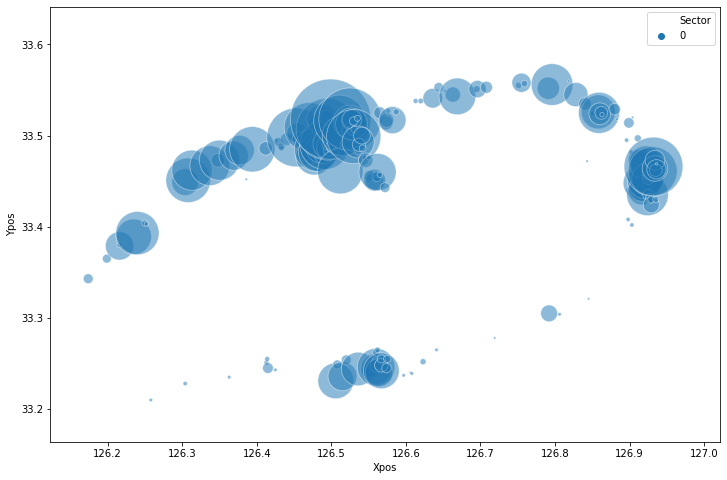

In [34]:
Scatter(OneSector_data)

In [35]:
OneSector_data = OneSector_data.groupby(['rent_date','Sector'],as_index=False).sum()
OneSector_data = WholePreprocessing(OneSector_data)
OneSector_data = Smoothing(OneSector_data)

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


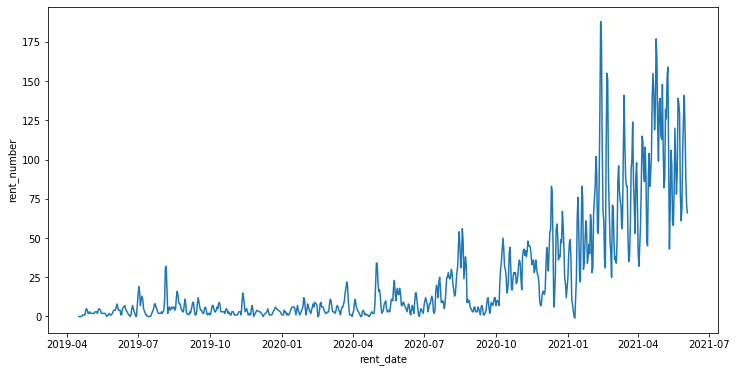

In [36]:
plt.figure(figsize=(12,6))

plt.plot(OneSector_data['rent_date'],OneSector_data['rent_number'])
plt.xlabel('rent_date')
plt.ylabel('rent_number')

plt.show()

In [37]:
OneSector_data['rain'] = OneSector_data['rain'].astype(str).astype(int)

In [38]:
X_train,X_test,y_train,y_test = OneSector_split(OneSector_data)
xlf = lgb.LGBMRegressor()
xlf.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
original_y_test_index,xgb_preds = PrintResult(y_test,xlf,X_test)

RMSE:  13.05482942931739
R2 SCORE 0.75


In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, xgb_preds)

11.0

In [41]:
def mean_absolute_percentage_error(y_test, xgb_preds): 
    y_test, xgb_preds = np.array(y_test), np.array(xgb_preds)
    return np.mean(np.abs((y_test - xgb_preds) / y_test)) * 100
print(mean_absolute_percentage_error(y_test, xgb_preds))

11.195388005683652


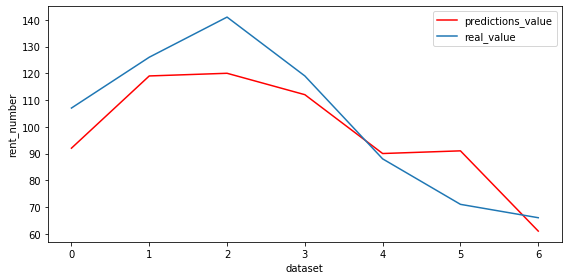

In [42]:
Plot(xgb_preds,y_test)

## Error 추가

# 지역 두개

In [43]:
TwoSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470
1,2019-04-20,1,EVS_000001,20,Saturday,126.499,33.518
2,2019-04-21,1,EVS_000001,21,Sunday,126.499,33.518
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470
...,...,...,...,...,...,...,...
11643,2021-06-03,2,EVS_000108,3,Tuesday,126.574,33.245
11644,2021-06-03,0,EVS_000110,3,Tuesday,126.482,33.482
11645,2021-06-03,0,EVS_000359,3,Tuesday,126.919,33.445
11646,2021-06-03,2,EVS_000285,3,Tuesday,126.550,33.476


In [44]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
Two_points = pd.DataFrame().reset_index(drop=True)
Two_points['Xpos'] = TwoSector_data['Xpos']
Two_points['Ypos'] = TwoSector_data['Ypos']
kmeans = KMeans(n_clusters=2)
kmeans.fit(Two_points)
TwoSector_data['Sector'] = kmeans.labels_

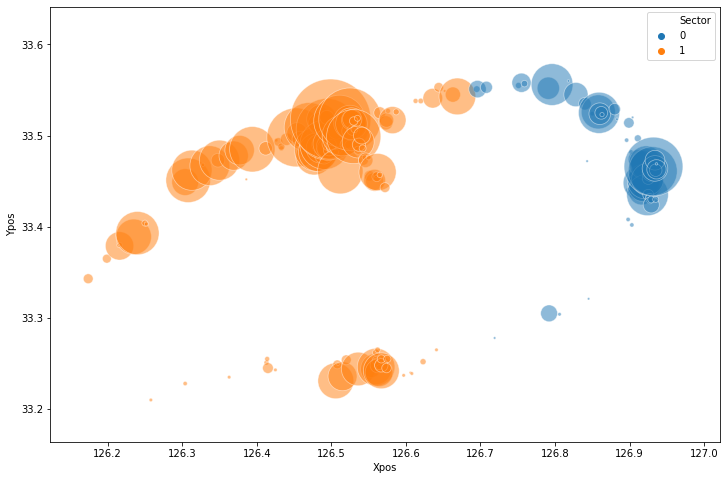

In [45]:
Scatter(TwoSector_data)

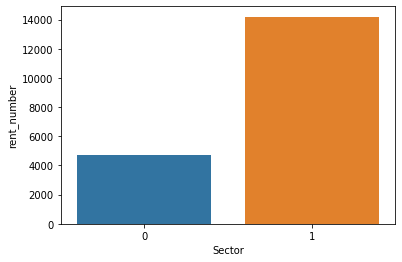

In [46]:
Barplot(TwoSector_data)

In [47]:
TwoSector_data = WholePreprocessing(TwoSector_data)
TwoSector_data = Smoothing(TwoSector_data)

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
TwoSector_data['rain'] = TwoSector_data['rain'].astype(str).astype(int)

In [49]:
Two_X_train,Two_X_test,Two_y_train,Two_y_test = TwoSector_split(TwoSector_data)
Two_xlf = lgb.LGBMRegressor()
Two_xlf.fit(Two_X_train, Two_y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
original_y_test_index,Two_xgb_preds = PrintResult(Two_y_test,Two_xlf,Two_X_test)

RMSE:  11.526367287968176
R2 SCORE 0.41


In [51]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Two_y_test, Two_xgb_preds)

10.142857142857142

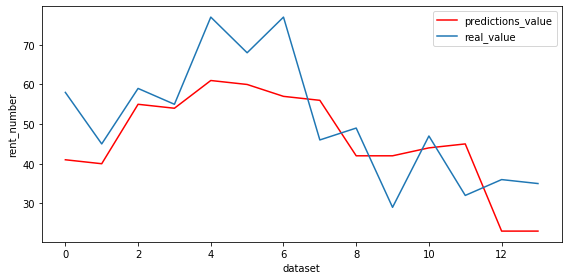

In [52]:
Plot(Two_xgb_preds,Two_y_test)

## Error 추가

# 지역 4개

In [53]:
FourSector_data

,rent_date,rent_number,rent_station,day,day_name,Xpos,Ypos
0,2019-04-16,1,EVS_000003,16,Tuesday,126.922,33.470
1,2019-04-20,1,EVS_000001,20,Saturday,126.499,33.518
2,2019-04-21,1,EVS_000001,21,Sunday,126.499,33.518
3,2019-04-24,2,EVS_000003,24,Wednesday,126.922,33.470
4,2019-04-25,3,EVS_000003,25,Thursday,126.922,33.470
...,...,...,...,...,...,...,...
11643,2021-06-03,2,EVS_000108,3,Tuesday,126.574,33.245
11644,2021-06-03,0,EVS_000110,3,Tuesday,126.482,33.482
11645,2021-06-03,0,EVS_000359,3,Tuesday,126.919,33.445
11646,2021-06-03,2,EVS_000285,3,Tuesday,126.550,33.476


In [54]:
from sklearn.cluster import KMeans
Four_points = pd.DataFrame().reset_index(drop=True)
Four_points['Xpos'] = FourSector_data['Xpos']
Four_points['Ypos'] = FourSector_data['Ypos']
kmeans = KMeans(n_clusters=4)
kmeans.fit(Four_points)
FourSector_data['Sector'] = kmeans.labels_

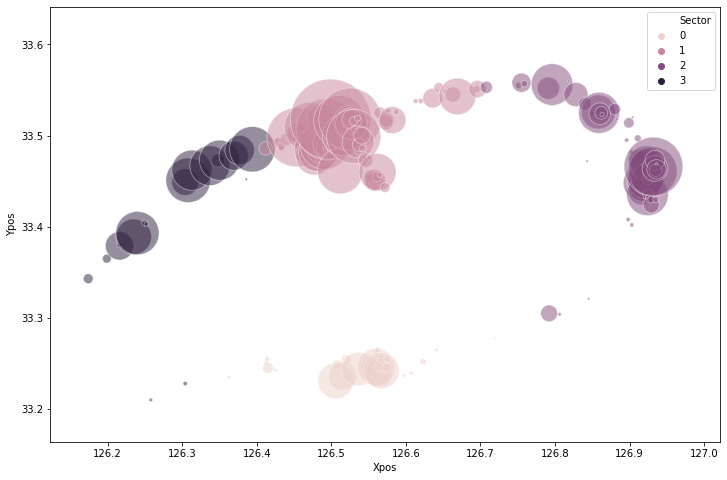

In [55]:
Scatter(FourSector_data)

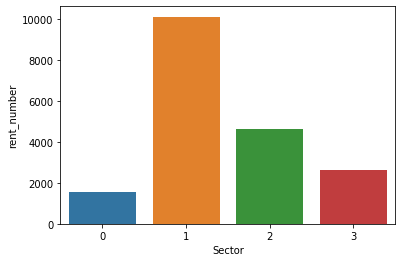

In [56]:
Barplot(FourSector_data)

In [57]:
FourSector_data = WholePreprocessing(FourSector_data)
FourSector_data = Smoothing(FourSector_data)

C:\Users\mllab\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
FourSector_data['rain'] = FourSector_data['rain'].astype(str).astype(int)

In [59]:
Four_X_train,Four_X_test,Four_y_train,Four_y_test = FourSector_split(FourSector_data)
Four_xlf = lgb.LGBMRegressor()
Four_xlf.fit(Four_X_train, Four_y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [60]:
original_y_test_index,Four_xgb_preds = PrintResult(Four_y_test,Four_xlf,Four_X_test)

RMSE:  5.460899978156401
R2 SCORE 0.75


In [61]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Four_y_test, Four_xgb_preds)

4.178571428571429

In [62]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mean_absolute_percentage_error(Four_y_test, Four_xgb_preds))

20.13993769841534


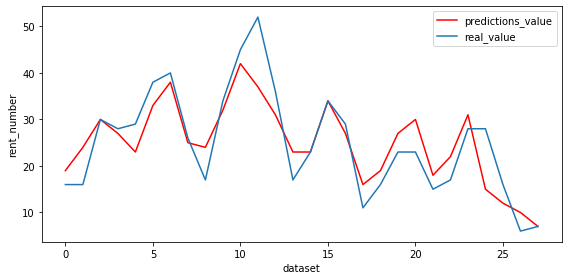

In [63]:
Plot(Four_xgb_preds,Four_y_test)


## Error 추가